In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Terrestrial fluxes

## Notebook 04: Make 'best' river flux dataset

Here we read in the two versions of simulated flow, as well as observed data where available. We then:
- Based on results of comparison to observations, pick the "best" simulated data and use that series.
- Where observations are available (and of sufficient quality), replace simulated data with observations. Small gaps should be interpolated (TO DO).
- Move the date to the 15th of the month, for use in marine modelling.

## User input

In [8]:
output_dir = "/home/jovyan/shared/common/catchment2coast/riv_fluxes"
q_sim_fname = "q_sim_both_methods.csv"

best_sim_col = 'q_sim-mean'  # one of cols in q_sim_fname

# Old, for reusing order4 gts-api data (diff elvids to catchs based on hovedelver tho)
# output_dir = "/home/jovyan/shared/common/catchment2coast/riv_fluxes/trfinn-not-varanger_minorder5"
# output_dir_order4 = "/home/jovyan/shared/common/catchment2coast/riv_fluxes/troms-finmark-minorder4"

st_dt = "2018-01-01"  # drop 2017, GTS API dodgy then
end_dt = "2023-12-31"  # Only downloaded simulations to end 2023

drop_obs_stations = [328]  # elvids

## Read in data

In [4]:
flow_csv_path = os.path.join(output_dir, "csv", q_sim_fname)
df = pd.read_csv(flow_csv_path)
# TODO: if only reading in scale_vassoms or gts-api, deal with renaming col
# to q_scale-vassoms or q_gts-api

df.head()

,elvid,date,q_scale-vassoms,q_gts-api,q_sim-mean
0,2,2018-01-01,1.613591,0.767192,1.190391
1,2,2018-02-01,1.248788,0.767618,1.008203
2,2,2018-03-01,1.067233,0.433712,0.750473
3,2,2018-04-01,2.031468,0.399219,1.215343
4,2,2018-05-01,14.228752,16.028459,15.128605


In [6]:
# Read in obs
qobs_fpath = os.path.join(output_dir, "csv", "observed_q.csv")
qobs_df = pd.read_csv(qobs_fpath)

# Drop any stations with rubbish observations (determined in previous notebook)
qobs_df = qobs_df.loc[~qobs_df['elvid'].isin(drop_obs_stations), :]

# Add so ready for merging with sim
qobs_df['par'] = 'q_obs'

qobs_df

,elvid,date,value,par
0,53.0,2018-01-01,0.912142,q_obs
1,53.0,2018-02-01,0.786934,q_obs
2,53.0,2018-03-01,0.241845,q_obs
3,53.0,2018-04-01,2.587106,q_obs
4,53.0,2018-05-01,9.428712,q_obs
...,...,...,...,...
1435,761.0,2023-08-01,1.603585,q_obs
1436,761.0,2023-09-01,2.753989,q_obs
1437,761.0,2023-10-01,3.124041,q_obs
1438,761.0,2023-11-01,1.531794,q_obs


In [7]:
# Make sure no NaNs in observed. If present, fill with linear interpolation (TODO!)

# Check for NaNs in elvid column
nan_elvids = qobs_df[qobs_df['elvid'].isna()]
if not nan_elvids.empty:
    print("Rows with NaNs in elvid column:")
    print(nan_elvids)
else:
    print("No NaNs found in elvid column.")

# Check for NaNs in discharge column
nan_q = qobs_df[qobs_df['value'].isna()]
if not nan_q.empty:
    print("Rows with NaNs in discharge column:")
    print(nan_q)
else:
    print("No NaNs found in discharge column.")

qobs_df = qobs_df.rename({'value': 'q_obs'}, axis=1)

No NaNs found in elvid column.
No NaNs found in discharge column.


In [19]:
# Join simulated and observed, long format
df_long = df.melt(id_vars=["elvid", "date"], var_name="par")
df_long = pd.concat([df_long, qobs_df])
df_long['date'] = pd.to_datetime(df_long['date'])
df_long = df_long.reset_index(drop=True)

,elvid,date,par,value
0,2.0,2018-01-01,flow_m3/s,1.613591
1,2.0,2018-02-01,flow_m3/s,1.248788
2,2.0,2018-03-01,flow_m3/s,1.067233
3,2.0,2018-04-01,flow_m3/s,2.031468
4,2.0,2018-05-01,flow_m3/s,14.228752
...,...,...,...,...
9787,761.0,2023-08-01,q_obs,1.603585
9788,761.0,2023-09-01,q_obs,2.753989
9789,761.0,2023-10-01,q_obs,3.124041
9790,761.0,2023-11-01,q_obs,1.531794


In [16]:
# # Old
# area_scale_fpath = os.path.join(output_dir, "csv", "flows_scale_vassoms.csv")
# q_df = pd.read_csv(area_scale_fpath)

# elvid_li = q_df['elvid'].unique()

# q_gwb_fpath = os.path.join(output_dir_order4, "csv", "flows_gts-api.csv")
# gwb_df = pd.read_csv(q_gwb_fpath)

# # Drop order 4 rivers and rivers from outside the slightly reduced domain (Varanger)
# gwb_df = gwb_df[gwb_df['elvid'].isin(q_df['elvid'])]
# gwb_df = gwb_df[gwb_df['date'] >= st_dt].reset_index(drop=True)

# gwb_df

## Make output file

In [16]:
out_df = pd.merge(df, qobs_df[['elvid', 'date', 'q_obs']], on=['elvid', 'date'], how='left')

# Pick mean of two simulations as the best
out_df["q_m3/s"] = out_df[best_sim_col]

# Replace simulated with observed when available
obs_elvid_li = qobs_df['elvid'].unique()  # list of river IDs containing obs
idx_to_replace = out_df['elvid'].isin(obs_elvid_li)
out_df.loc[idx_to_replace, "q_m3/s"] = out_df.loc[idx_to_replace, 'q_obs']

# Drop all but the 'best' discharge estimate
out_df = out_df[['elvid', 'date', "q_m3/s"]]

# Unstack to have one column per elvid
out_df = out_df.pivot(index='date', columns='elvid', values="q_m3/s")

# Slice to be within the start and end dates
out_df.index = pd.to_datetime(out_df.index)
out_df = out_df.loc[st_dt:end_dt]

# Shift the day of the month from the first to the fifteenth for all months
out_df.index = out_df.index + pd.DateOffset(days=14)

# Quick final NaN check
nan_check = out_df.isna().sum().sum()
if nan_check > 0:
    print("NaNs in the df")
else:
    print("No NaNs in the df")

# Round to 2 d.p.
out_df = out_df.round(2)

# Save
st_yr = pd.to_datetime(st_dt).year
end_yr = pd.to_datetime(end_dt).year
out_df.to_csv(os.path.join(output_dir, "csv", f"q_sim-obs-merged_{st_yr}-{end_yr}.csv"))

out_df

No NaNs in the df


elvid,2,5,7,11,32,34,37,41,42,44,...,839,842,844,845,850,851,856,870,872,873
date,,,,,,,,,,,,,,,,,,,,,
2018-01-15,1.19,0.73,1.28,0.47,0.91,0.76,1.35,0.65,0.82,0.93,...,0.92,0.58,0.19,0.29,0.34,0.43,0.37,0.55,0.50,0.36
2018-02-15,1.01,0.66,1.06,0.40,0.85,0.57,1.18,0.67,0.63,0.79,...,0.68,0.40,0.14,0.22,0.25,0.35,0.26,0.44,0.40,0.28
2018-03-15,0.75,0.47,0.80,0.24,0.55,0.44,0.88,0.48,0.50,0.62,...,0.71,0.39,0.13,0.25,0.23,0.43,0.24,0.45,0.46,0.33
2018-04-15,1.22,0.73,1.25,0.48,1.97,1.22,1.45,1.09,1.80,1.17,...,0.65,0.37,0.11,0.24,0.18,0.46,0.20,0.47,0.49,0.31
2018-05-15,15.13,9.11,14.26,7.32,12.85,8.72,19.03,6.42,13.51,14.40,...,10.11,6.49,5.80,5.84,10.29,6.41,6.83,12.32,10.17,7.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-15,10.38,4.33,10.40,1.95,0.99,3.34,4.38,2.86,1.57,5.64,...,3.11,1.39,1.36,1.13,1.81,1.33,2.97,1.79,1.29,0.99
2023-09-15,9.51,4.50,8.21,3.30,2.35,2.74,4.46,2.69,2.13,4.45,...,2.35,1.27,0.91,0.81,1.47,0.98,1.75,1.36,1.02,0.78
2023-10-15,3.21,1.79,2.93,1.29,1.65,1.26,2.61,1.12,1.87,2.09,...,2.52,1.50,0.59,0.84,1.30,1.00,1.67,2.11,1.80,1.40


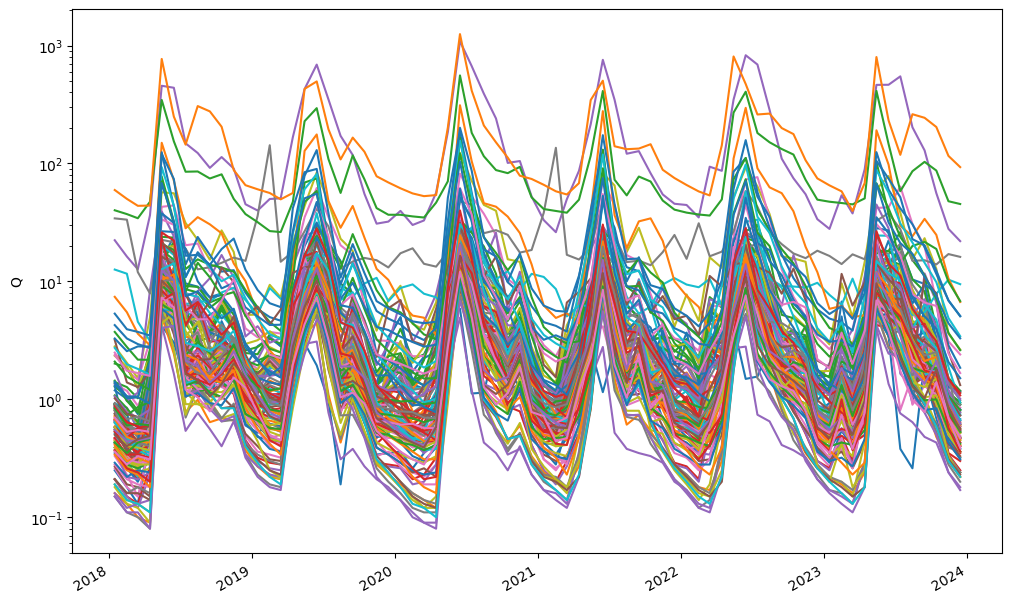

In [11]:
# Quick plot
out_df.plot(figsize=(12, 8), legend=False)
plt.yscale('log')
plt.ylabel('Q')
plt.xlabel('')
plt.show()